In [1]:
import sys
sys.path.append("/workdir/unsupervised_pretrain/")

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from datasets import SeriesEmbedDataset
from models import Hat, SeriesResNet18
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

In [3]:
ds = SeriesEmbedDataset(["/datasets/datasets/berlin/33UUU/"], size=512, series_length=8)

In [4]:
device = torch.device("cuda")

In [5]:
visual2text_hat = torch.load("/workdir/unsupervised_pretrain/hat1.pth", map_location=device).to(device)
visual2text_hat = visual2text_hat.eval()

In [6]:
model = torch.load("/workdir/unsupervised_pretrain/model.pth", map_location=device).to(device)
model = model.eval()

# Load and save #

This only needs to happen once.

In [7]:
visual_embeddings = []
text_embeddings = []
visual2text_embeddings = []

with torch.inference_mode():
    for i in tqdm(range(0, len(ds), 2)):
        imagery, _, text_embedding = ds[i]
        imagery = torch.unsqueeze(imagery.to(device), dim=0)

        visual_embedding = model(imagery)
        visual_embedding = F.normalize(visual_embedding, dim=1)
        visual2text_embedding = visual2text_hat(visual_embedding)
        visual2text_embedding = F.normalize(visual2text_embedding, dim=1)

        text_embedding = torch.unsqueeze(torch.from_numpy(text_embedding), dim=0).to(device)
        text_embedding = F.normalize(text_embedding, dim=1)

        visual_embedding = visual_embedding.detach().cpu()
        visual2text_embedding = visual2text_embedding.detach().cpu()
        text_embedding = text_embedding.detach().cpu()

        visual_embeddings.append(visual_embedding)
        text_embeddings.append(text_embedding)
        visual2text_embeddings.append(visual2text_embedding)

  0%|          | 0/648 [00:00<?, ?it/s]

In [8]:
text_embeddings = torch.cat(text_embeddings, dim=0).numpy()
np.save("/workdir/unsupervised_pretrain/jupyter/berlin-text-embeddings.npy", text_embeddings)

In [9]:
visual_embeddings = torch.cat(visual_embeddings, dim=0).numpy()
np.save("/workdir/unsupervised_pretrain/jupyter/berlin-visual-embeddings.npy", visual_embeddings)

In [10]:
visual2text_embeddings = torch.cat(visual2text_embeddings, dim=0).numpy()
np.save("/workdir/unsupervised_pretrain/jupyter/berlin-visual2text-embeddings.npy", visual2text_embeddings)

# Visualize #

In [11]:
text_embeddings = np.load("/workdir/unsupervised_pretrain/jupyter/berlin-text-embeddings.npy")
text_mask = (text_embeddings[:, 0] >= torch.inf) + (np.isnan(text_embeddings[:, 0]))
text_embeddings[text_mask] = 1.
text_embeddings /= np.linalg.norm(text_embeddings, axis=1, keepdims=True)

In [12]:
visual_embeddings = np.load("/workdir/unsupervised_pretrain/jupyter/berlin-visual-embeddings.npy")
visual_embeddings /= np.linalg.norm(visual_embeddings, axis=1, keepdims=True)

In [13]:
visual2text_embeddings = np.load("/workdir/unsupervised_pretrain/jupyter/berlin-visual2text-embeddings.npy")
visual2text_embeddings /= np.linalg.norm(visual2text_embeddings, axis=1, keepdims=True)

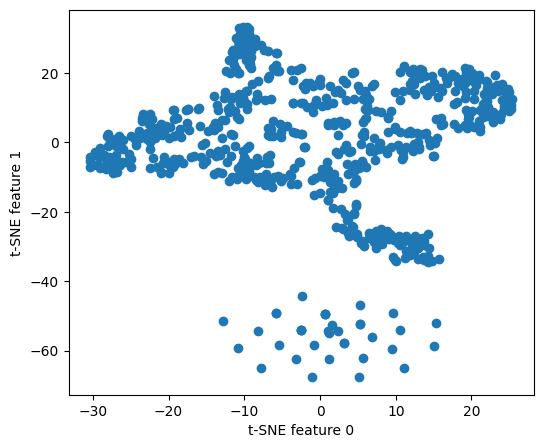

In [14]:
tsne = TSNE(n_components=2, random_state=0)

data_2d1 = tsne.fit_transform(visual_embeddings)

# plot the result
plt.figure(figsize=(6, 5))
plt.scatter(data_2d1[:, 0], data_2d1[:, 1])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()

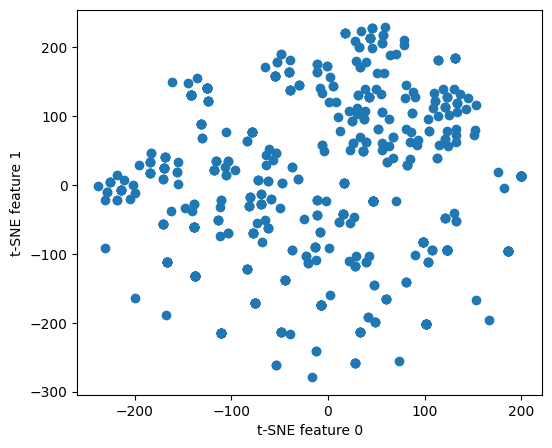

In [15]:
tsne = TSNE(n_components=2, random_state=0)

data_2d1 = tsne.fit_transform(text_embeddings)

# plot the result
plt.figure(figsize=(6, 5))
plt.scatter(data_2d1[:, 0], data_2d1[:, 1])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()

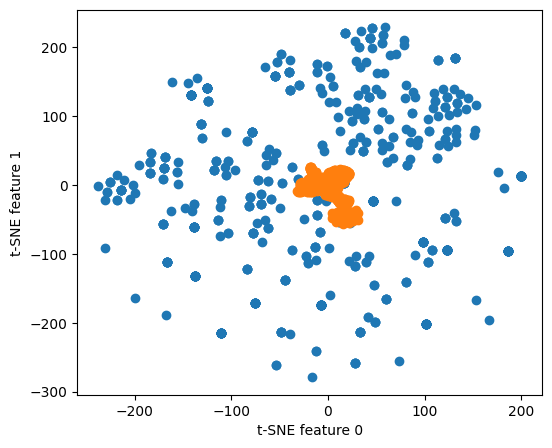

In [16]:
tsne = TSNE(n_components=2, random_state=0)

data_2d1 = tsne.fit_transform(text_embeddings)
data_2d2 = tsne.fit_transform(visual2text_embeddings)

# plot the result
plt.figure(figsize=(6, 5))
plt.scatter(data_2d1[:, 0], data_2d1[:, 1])
plt.scatter(data_2d2[:, 0], data_2d2[:, 1])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()

In [ ]:
np.linalg.norm(text_embeddings, axis=1, keepdims=True)[42]

In [ ]:
np.linalg.norm(visual2text_embeddings, axis=1, keepdims=True)[42]

In [ ]:
text_embeddings[42].shape

In [ ]:
visual2text_embeddings[42].shape

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist